# Preprocessing des données catalogue
## Généralités
Pour optimiser le temps de calcul et de traitement des nombreuses données disponibles dans les catalogues des constructeurs, il faut en faire un preprocessing. De plus, il est également important de vérifier qu'il n'y ai pas deux références identiques car l'interpolation utilisée dans la phase d'optimisation ne peux pas fonctionner si il existe un doublon.
Par conséquent, nous utilisons deux algorithmes que nous détaillerons dans cette partie, un algorithme de _filtrage minimum maximum_ et un algorithme de _filtrage de Pareto_.

Pour le preprocessing nous utilisons une classe qui contient deux méthodes qui effectuerons les deux algorithme de preprocessing.
Pour des raisons d'optimisation et de simplicité de code, nous avons utilisés le package _numpy_ de python.
Pour cette raison, la class preprocessing accepte comme argument data de type array numpy (_np.array_) qui contient les données que nous souhaitons filtrer.
Le constructeur de la classe créé trois variables data de type np.array, \__originalData_, qui correspond à une copie des données originales utilisées en paramètres, qui servent uniquement pour des raisons de backup. Les \__lastData_ correspondent elles aux dernières données après modifications par les algorithmes des méthodes de la classe.
Finalement, les _modifiedData_ aux seules données publiques de la classe et comprennent les données avec les modifications succécives par les algorithme de préprocessing.
Pour les besoins de la méthode de filtrage minimum maximum, il est également nécéssaire de garder en mémoire les valeurs maximales et minimales pour les données sur différents axes qui sont stockées dans la liste \__initialboundaries_.

Cependant, comme les donées catalogues sont fournies sous forme de fichier csv (coma separated value, soit données séparées par des virgules), nous devons tout d'abord les importer et les exporter sous la forme de np.array. Pour cela nous utilisons le package pandas, initialement prévu pour le traitement statistique, pour lire le fichier csv. Il faut cependant faire attention à ne pas avoir de ligne de texte dans le fichier avant de le convertir en nd.array.

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

class preprocessing :
    
    def __init__(self, data:np.array)->None:
        """Attribution des valeurs à Original Data et modifiable data"""
        self._originalData = data
        self._lastData = data
        #renvoie la liste des valeurs minimales pour tous les axes, reshape pour forcer un vecteur
        minbound = np.amin(data, axis=0).reshape(-1,)
        maxbound = np.amax(data, axis=0).reshape(-1,)
        #a et b se baladent dans les liste des min et max, et renvoi liste de tuples pour chaque axes
        self._initialboundaries = [(a, b) for a, b in zip(minbound, maxbound)]
        self.modifiedData = data   
        return
    
motors = pd.read_csv('motorsdatas.csv').values
plt.scatter(motors[:,2], motors[:,3])

## Filtrage Min / Max

Le principe du filtrage minimum maximum est de conserver seuelement les données dont les valeurs sont comprises entre deux bornes. Pour cela, la méthode filtrage prend en argument une variable _bornes_ de type list, qui contient les bornes pour chaque axe. Le deuxième paramètre facultatif est un booléen qui permet de choisir si l'on veut utiliser les \__originalData_, c'est à dire revenir à zéro au niveau des modifications éventuellement apportées, ou utiliser les dernières modifiées, ce que la méthode fait par défaut.
Par la suite, l'algorithme parcourt un à un les axes du nd.array pour comparer chacune des valeurs aux bornes pour pouvoir les intégrer ou non au nd.array _temp_ qui sera transmis en résultat, en devenant également les \__lastData_.


In [3]:
def filtrage (self, bornes:list, last = True)->np.array:    
        temp = self._lastData if last else self._originalData
        for axe in range(self._originalData.shape[1]):
            temp = np.array([row for row in temp if  bornes[axe,0]<row[axe] and row[axe]<bornes[axe,1]])
        self._lastData = temp
        return temp
preprocessing.filtrage = filtrage

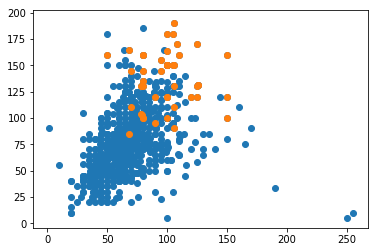

In [4]:
instance = preprocessing(motors)

bornes =np.array([(0,800),
                 (600,800),
                 (0, 200),
                 (0, 200),
                 (0, 200),
                 (0, 200),
                 (0, 200),
                 (0, 200)
                 ])
demo = instance.filtrage(bornes)
plt.scatter(motors[:,2], motors[:,3])
plt.scatter(demo[:,2], demo[:,3])
plt.show()

## Filtrage de Pareto

L'optimum de Pareto est une allocation des ressources pour laquelle il n'existe pas une alternative dans laquelle tous les acteurs seraient dans une meilleure position. Cette notion permet de diviser en deux l'ensemble des options possibles :

 * Les points non-dominants (ceux qui sont uniformément améliorables) : il est possible d'augmenter le bien-être de certains individus sans réduire celui des autres.
 * Les points dominants (ceux qui ne sont pas uniformément améliorables) : l'augmentation du bien-être de certains individus implique la réduction du bien-être d'au moins un autre individu.

Le principe du filtrage de Pareto est, en utilisant la notion d’optimum de Pareto, de conserver les points qui font partie du front Pareto, c’est-à-dire, les points dominants.


In [7]:
def pareto (self, axes:np.array, modified = True )->np.array:
        if modified == True :
            datas = self.modifiedData
        else:
            datas = self._originalData
        axes = np.sort(axes)#Tri des axes
        #Création de la liste des axes à enlever
        axesASupprimer = np.array([])
        for i in np.arange(datas.shape[1]):
            if i not in axes:
                axesASupprimer = np.append(axesASupprimer, i)
            #Suppresion des axes inutiles
        datasModif = np.delete(datas, axesASupprimer, 1)
            #Vérifier si les points sont pareto optimaux ou non
            #Retourne un tableau de booléen pour chaque point
            #Création du tableau de booléens, de la même taille que le nb de pts
        isPareto = np.ones(datasModif.shape[0], dtype =bool)
            #Créé le tableau de résultat qui contient uniquement les point Po*
        for i, value in enumerate(datasModif):
            for j, other_value in enumerate(datasModif):
                different_terms = (i!=j)#Il ne faut pas que deux points identiques se comparent entre eux
                if different_terms and isPareto[i] == True: #On sort dès que l'on trouve un comparaison Fausse
                    isPareto[i] = np.all(np.any(value>other_value))
        result = None
        for index,v in enumerate(isPareto):
            if v:
                if result is None:
                    # first term
                    result = np.copy(datas[index].reshape(1,-1))
                else:
                    # other terms
                    result = np.concatenate( (result,datas[index].reshape(1,-1)),axis=0 )
            #retour
        self.modifiedData = result
        return result
    
preprocessing.pareto = pareto

C:\Users\Matthieu\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  del sys.path[0]


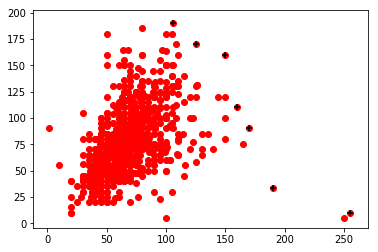

In [8]:
choixPareto = np.array([2,3])#Liste des axes que l'on choisi pour Pareto
demo = instance.pareto(choixPareto)#Appel du filtrage pareto
demo = demo[demo[:,2].argsort()]
plt.scatter(motors[:,2], motors[:,3], c='red')
plt.scatter(demo[:,2], demo[:,3],marker='+', c='black', label='MultiAxis Pareto')
plt.show()